# UNIDAD 3 Métodos de Agrupamiento 

## Alumno: José Antonio García Casanova

## Introducción

En esta sección implementaremos algoritmos de clustering sobre dos conjuntos de datos:

- Iris: Conjuntos de datos multivariable (setosa, versicolor, virginica)  el cual contiene las siguientes variables:
    - largo de sépalo;
    - ancho de sépalo;
    - largo de pétalo y;
    - ancho de pétalo.
    
- Wine: Conjunto de datos multivariable (class 0, class 1, class 2) el cual contiene las siguientes variables:
    - alcohol;
    - ácido málico; 
    - cenizas
    - alcalinidad de cenizas
    - magnesio
    - fenoles totales
    - flavonoides
    - fenoles no flavonoides
    - proantocianidinas
    - intensidad color
    - matiz
    - od280/od315 de vinos diluidos
    - prolina
    
Ambos conjuntos de datos son extraídos de la librería de **sklearn**.
 
Para este ejercicio intentaremos agrupar los datos utilizando las técnicas revisadas en la unidad 3A. Estas técnicas de clustering buscarán dividir el conjunto de datos en objetos similares y buscará separar los objetos que son diferentes. 

Para el presente ejercicio se utilizará un algoritmo particional (**K-Means**) y uno jerárquico para generar los clusters, en los algoritmos particionales se implementaran los métodos de **Elbow**, **Silueta** y **VAT** para determinar el número óptimo de clusters. Adicionalmente se compararan la calidad de los clusters obtenidos y se utilizarán las medidas internas y externas una vez que se haya hecho la agrupación de los datos.

## Desarrollo

### Cargan librerías necesarias para ambos conjuntos de datos

In [1]:
# Transformación de datos
import numpy as np
import pandas as pd
from sklearn import preprocessing

# Conjuntos de datos
from sklearn import datasets

# Importamos libería para clustering Jerárquico y KMeans 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans

# Importamos librería para métricas
from sklearn.metrics import silhouette_score, classification_report

# Importamos nuestra librería personalizada
from skeleton import *

Cargamos una funcion que anota el nombre del nodo en el dendograma:

In [2]:
def anota_dendograma(D, ax):
      bbox_props = dict(fc="white", ec="b",boxstyle='circle')
      ll=list(set(np.array(D['dcoord']).flatten()))
      ll.sort()
      for j, d in zip(D['icoord'], D['dcoord']):
        x = 0.5 * sum(j[1:3])
        y = d[1]
        #plt.plot(x, y, 'sr', markersize=10)
        ax.annotate("$C_{%d}$" %(ll.index(y)+len(X)-1) , (x, y), xytext=(0, 8),textcoords='offset points',va='top',size=9 ,ha='center', bbox=bbox_props)

### Iris

Cargamos nuestro conjunto de datos y utilizando `preprocessing` normalizaremos los datos:

In [3]:
iris = datasets.load_iris()

# Normalizamos los datos
X = preprocessing.normalize(iris.data)

### Algortimo Jerárquico

El primer algoritmo que vamos a implementar es el cluster jerárquico usando el código que se compartió, recordemos que para este algoritmo existen 4 criterios de unión:
- Single: Minimiza la distancia entre clusters;
- Complete: Minimiza la dsitancia máxima;
- Centroid: Minimiza la distancia entre los centroides;
- Ward: Minimiza la varianza de los clusters.

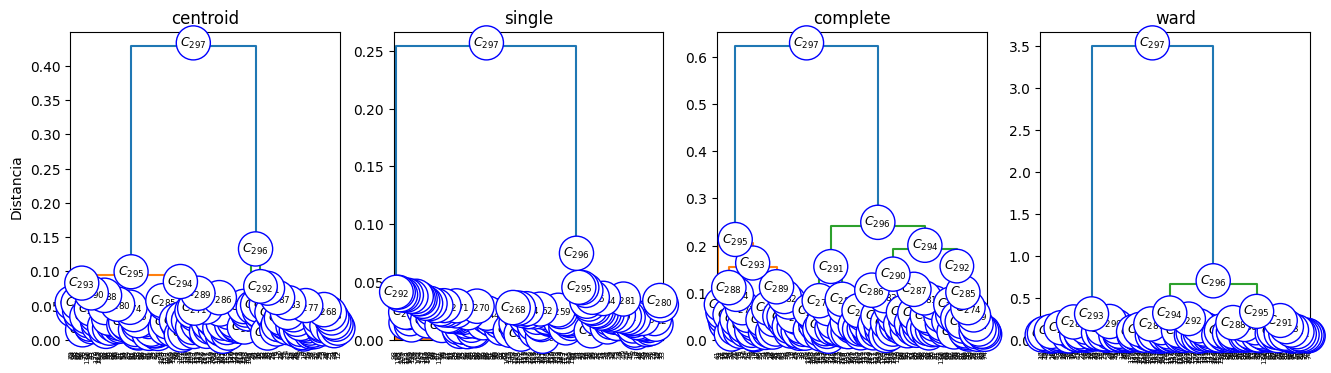

In [4]:
fig, axes = plt.subplots(1,4, figsize=(16,4))

axes[0].set_ylabel('Distancia')

linkage_type = ('centroid','single','complete', 'ward')

for i,lk in enumerate(linkage_type):
    
    Z = linkage(X, lk)
        
    Dz = dendrogram(Z, ax = axes[i])
    
    axes[i].set_title(lk)
        
    anota_dendograma(Dz,axes[i])

Utilizando este mismo método, intentaremos cortar el dendograma para formar nuestros clusters:

==============centroid==============
En centroid la ultima iteración se unen los clusters: (296.0, 297.0)
En centroid el costo es de: 0.4285181030443936
En centroid el número de elementos en C297 es: 150.0
==============single==============
En single la ultima iteración se unen los clusters: (293.0, 297.0)
En single el costo es de: 0.2537017722325306
En single el número de elementos en C297 es: 150.0
==============complete==============
En complete la ultima iteración se unen los clusters: (296.0, 297.0)
En complete el costo es de: 0.6225109563040844
En complete el número de elementos en C297 es: 150.0
==============ward==============
En ward la ultima iteración se unen los clusters: (294.0, 297.0)
En ward el costo es de: 3.498835660013823
En ward el número de elementos en C297 es: 150.0


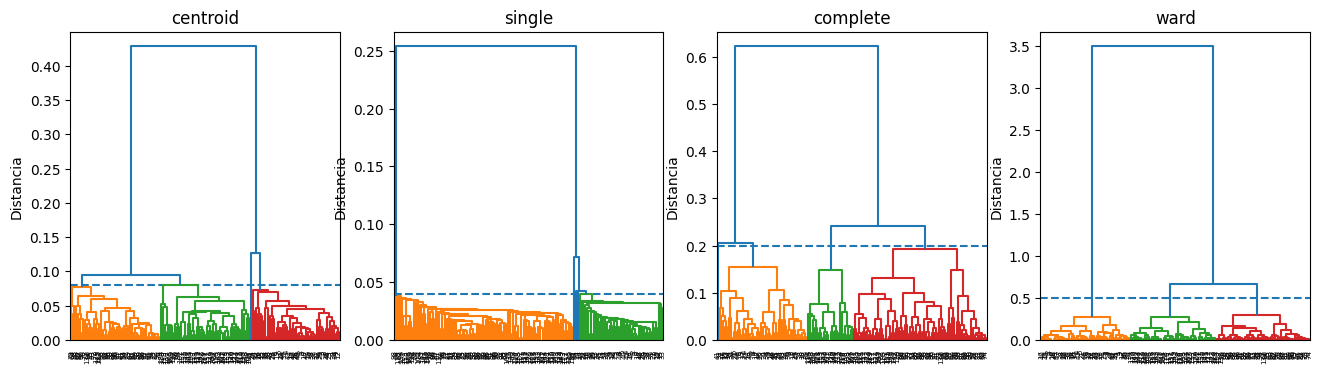

In [39]:
fig, axes = plt.subplots(1,4, figsize=(16,4))

linkage_type = ('centroid','single','complete', 'ward')
cutoff = (0.08, 0.04, 0.2, 0.5)
indexador = 0

for i in range(0,4):

    Z = linkage(X, linkage_type[i])
    axes[indexador].axhline(cutoff[i],
                            0,
                            5,
                            linestyle = 'dashed')
    Dz=dendrogram(Z, 
                  color_threshold = cutoff[i], 
                  ax = axes[indexador])
    
    axes[indexador].set_ylabel('Distancia')
    axes[indexador].set_title(linkage_type[i])
    
    if indexador + 1 == 4:
        pass
    else:
        indexador += 1
     
    print(f"=============={linkage_type[i]}==============")
    print(f"En {linkage_type[i]} la ultima iteración se unen los clusters:", (Z[148,0], Z[148,1]))
    print(f"En {linkage_type[i]} el costo es de:", Z[148,2])
    print(f"En {linkage_type[i]} el número de elementos en C297 es:", Z[148,3])

El criterio de unión *ward* minimiza el incremento de la varianza del clustering, como vemos, este criterio es el que al parecer, mejor separa los clusters teniendo un costo de 3.49.

Sabiendo el número de cluster procedemos a obtener las etiquetas mediante la función `fcluster`

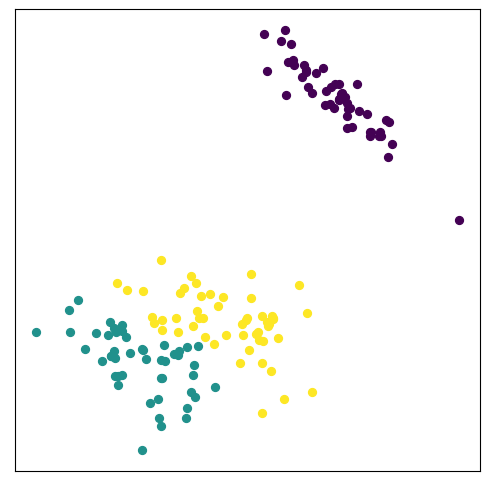

In [40]:
# Establecemos el número de clusters
clusters = 3 

# Obtenemos las etiqutas para cada cluster
y_hat = fcluster(Z, clusters, criterion='maxclust')

# Graficamos nuestro resultado
plotClusters(X, y_hat)

Como se puede apreciar, se han obtenido 3 clustres los cuales al parecer se encuentran bien diferenciados.

### Selección de clsuters para K-Means

Ahora avanzaremos a la implementación del algortimo K-Means, pero sabiendo que existen los métodos **Elbow**, **Silueta** y **Tendencia de evaluación visual (VAT)** para determinar el número óptimo de clusters, primero procederemos a implementar dichos métodos: 

#### Elbow

Este método consiste en estimar la suma de los errores al cuadrado (SSE), la cúal es la distancia de todos los objetos con respecto de los centroides, y elegir el número de clusters dónde la diferencia haya sido mayor con respecto al número de clusters anterior, utilizaremos el método inertia_ para guardar el SSE:

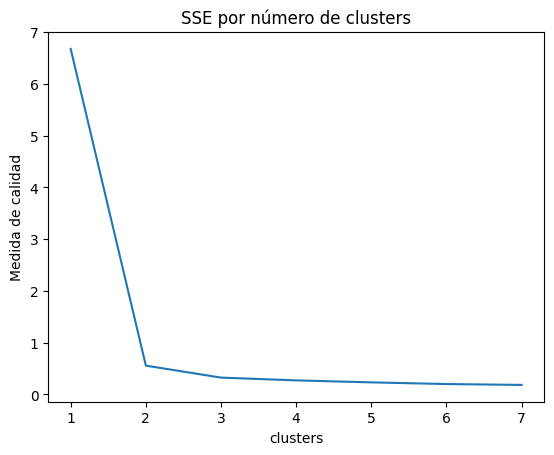

In [41]:
clusters = [x for x in range(1,8)]
sse_list = []

for cluster in clusters:
    modelo_kmeans = KMeans(n_clusters = cluster)
    modelo_kmeans.fit(X)
    sse_list.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1)
ax.set_xticks(clusters)
ax.set_title("SSE por número de clusters")
ax.set_xlabel('clusters')
ax.set_ylabel('Medida de calidad')
ax.plot(clusters, sse_list)

De acuerdo al criterio de selección **Elbow**, el número de clusters seleccionado es 3.

#### Silueta

Este método minimiza la distancia de los elementos del cluster y busca maximizar la distancia entre clusters.

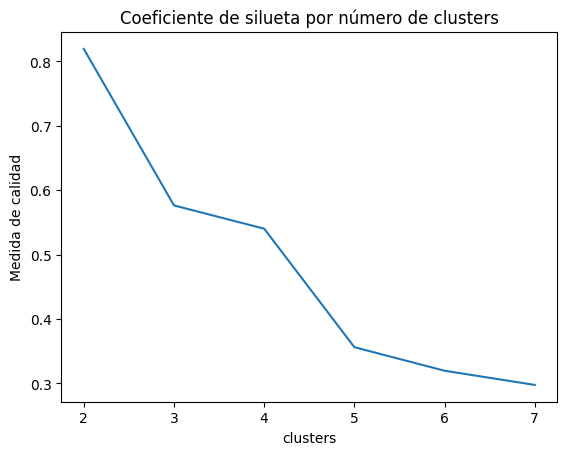

In [42]:
clusters = [x for x in range(2,8)]
lista_siluesta_score = []

for cluster in clusters:
    modelo_kmeans = KMeans(n_clusters = cluster)
    y_hat = modelo_kmeans.fit_predict(X)
    silueta_score = silhouette_score(X, y_hat)
    lista_siluesta_score.append(silueta_score)
    
fig, ax = plt.subplots(1, 1)
ax.set_xticks(clusters)
ax.plot(clusters, lista_siluesta_score)
ax.set_title("Coeficiente de silueta por número de clusters")
ax.set_xlabel('clusters')
ax.set_ylabel('Medida de calidad');

Para la seleccion del número de clusters bajo este criterio, se selecciona el valor máximo, en este caso es el 2 teniendo 0.8.

#### VAT

Es un enfoque visual que nos permite ver nubes de puntos basadas en X:

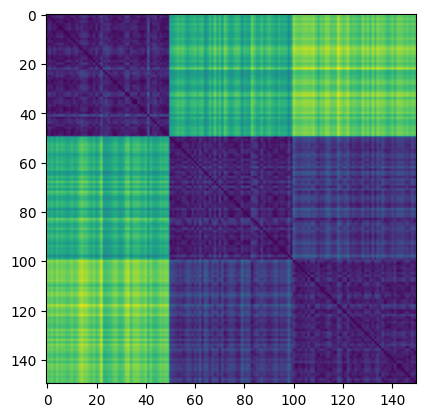

In [9]:
from scipy.spatial.distance import pdist, squareform

dist_euclidean = pdist(X, 'euclidean')

m = np.max(dist_euclidean)

n = len(X)

D = squareform(dist_euclidean)/m #Normalizamos entre el valor máximo

fig, ax = plt.subplots()
im = ax.imshow(D)

Como se puede apreciar, las nubes de puntos se agrupan en 3 zonas, la zona superior izquierda, una zona media y una última zona inferior derecha, de este modo podemos determinar que el número de clusters optimos de acuerdo a **VAT** es 3.

### Modelo K-Means 

Como podemos ver, en 2 de los 3 métodos para la elección del número de cluster óptimos, el resultado parece ser 3, por lo que a continuación se presenta el algoritmo **K-Means** para 3 clusters:

Text(0.5, 1.0, 'Clusters = 3')

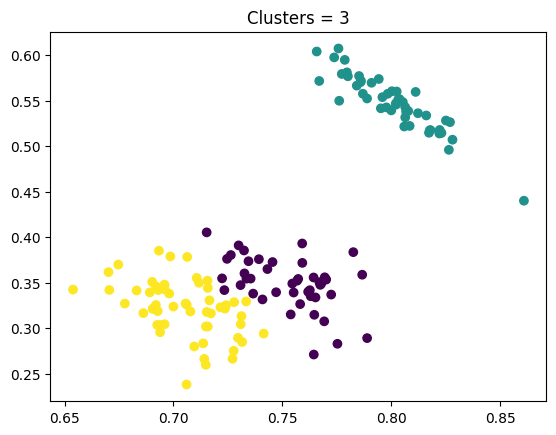

In [43]:
fig, ax = plt.subplots(1, 1)

model_kmeans = KMeans(n_clusters = 3)
y_hat = model_kmeans.fit_predict(X = X)
ax.scatter(x = X[:, 0],
           y = X[:, 1], 
           c = y_hat)

ax.set_title('Clusters = 3')

### Comparativa de calidad

#### Medidas Internas

Para el SSE tenemos el método `inertia_` que permite obtener el SSE por cada cluster añadido, estos resultados los guardamos en la variable `sse_list`:

In [11]:
sse_list

[6.6753305099685045,
 0.5544050220763209,
 0.3226817404832856,
 0.2693043948533789,
 0.23079937723087343,
 0.19886168517648728,
 0.18233754583597964]

Para el coeficiente de Silueta utilizamos el método `silhouette_score` y los resultados lo guardamos en la variable `lista_siluesta_score`:

In [12]:
lista_siluesta_score

[0.81924350789413,
 0.576326476810026,
 0.5402408637509504,
 0.35355149692501964,
 0.31607906960684184,
 0.2954501917527895]

#### Medidas Externas

Para la evaluación del **recall**, **precision** y **F1** utilizaremos la función `classification_report()` que se encuentra en la librería de `metrics` de `sklearn`. En este caso tenemos que hacer un reajuste de los datos ya que se quiere comparar sí la agrupación fue correcta, no si el etiquetado lo fue:

In [46]:
y_hat_fix = []

for i in y_hat:
    if i == 0:
        y_hat_fix.append(1)
    elif i == 1:
        y_hat_fix.append(0)
    else:
        y_hat_fix.append(i)

y_hat_fix = np.array(y_hat_fix)

In [47]:
print(classification_report(iris.target, np.array(y_hat_fix)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.90      0.95        50
           2       0.91      1.00      0.95        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



Primero mencionemos que significa cada una de estas 3 métricas (Precisión, Recall, F1-Score):

- Precisión: Indica el porcentaje de casos verdaderamente positivos que el algortimo marco como positivos;
- Recall: Indica el porcentaje de casos verdaderamente positivos sobre los casos efectivamente positivos;
- F1-Score: Combina ambas medidas en un solo valor, es una manera de medir el rendimiento combinado.

Para este caso nuestro algortimo marca tanto la precisión macro, recall macro y F1-score tun valor del 97%. 

Pasemos a nuestro otro conjunto de datos.

## Wine

Cargamos nuestro conjunto de datos y utilizando `preprocessing` normalizaremos los datos:

In [70]:
wine = datasets.load_wine()

# Normalizamos los datos
X = preprocessing.normalize(wine.data)

### Algortimo Jerárquico

Aplicamos nuestro algortimo jerárquico:

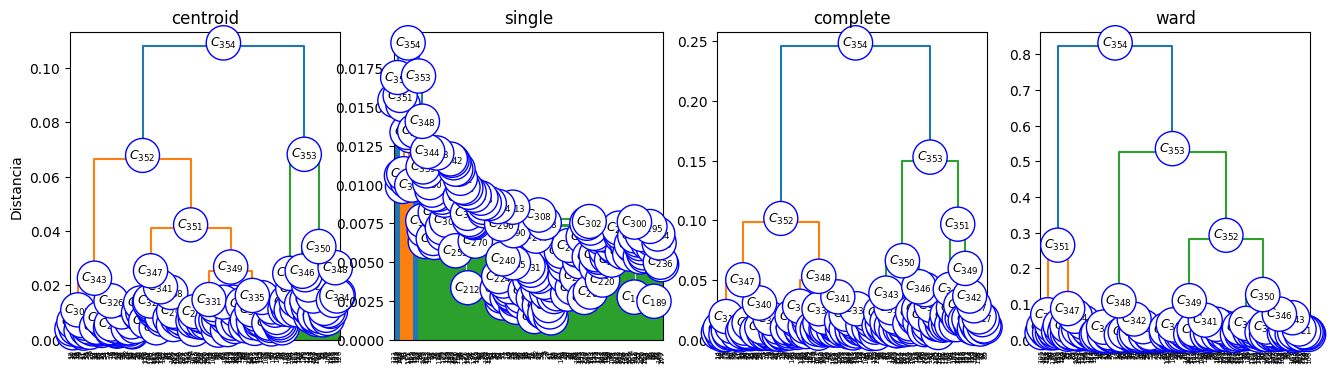

In [49]:
fig, axes = plt.subplots(1,4, figsize=(16,4))

axes[0].set_ylabel('Distancia')

linkage_type = ('centroid','single','complete', 'ward')

for i,lk in enumerate(linkage_type):
    
    Z = linkage(X, lk)
        
    Dz = dendrogram(Z, ax = axes[i])
    
    axes[i].set_title(lk)
        
    anota_dendograma(Dz,axes[i])

==============centroid==============
En centroid la ultima iteración se unen los clusters: (352.0, 353.0)
En centroid el costo es de: 0.10793803814416422
En centroid el número de elementos en C354 es: 178.0
==============single==============
En single la ultima iteración se unen los clusters: (352.0, 353.0)
En single el costo es de: 0.018890963315085506
En single el número de elementos en C354 es: 178.0
==============complete==============
En complete la ultima iteración se unen los clusters: (352.0, 353.0)
En complete el costo es de: 0.24556623211816073
En complete el número de elementos en C354 es: 178.0
==============ward==============
En ward la ultima iteración se unen los clusters: (351.0, 353.0)
En ward el costo es de: 0.8215584081644233
En ward el número de elementos en C354 es: 178.0


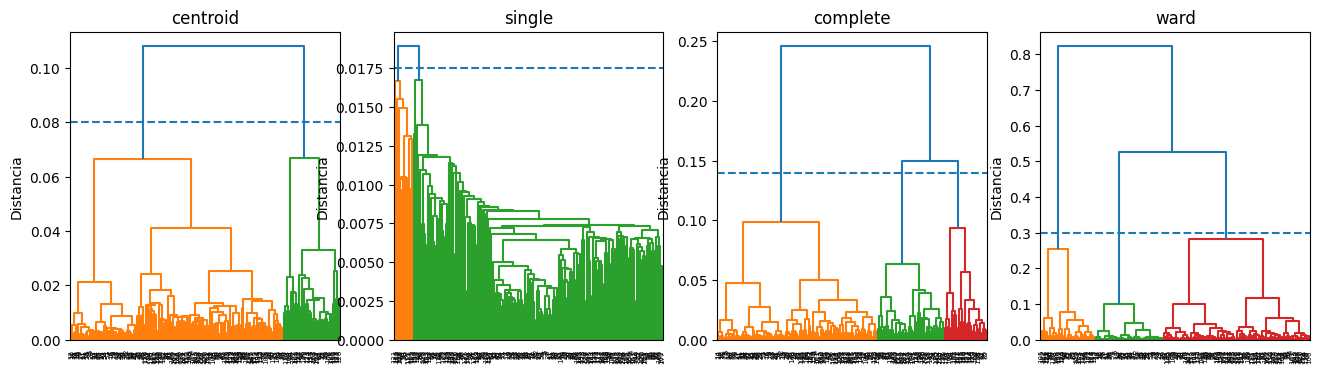

In [50]:
fig, axes = plt.subplots(1,4, figsize=(16,4))

linkage_type = ('centroid','single','complete', 'ward')
cutoff = (0.08, 0.0175, 0.14, 0.3)
indexador = 0

for i in range(0,4):

    Z = linkage(X, linkage_type[i])
    axes[indexador].axhline(cutoff[i],
                            0,
                            5,
                            linestyle = 'dashed')
    Dz=dendrogram(Z, 
                  color_threshold = cutoff[i], 
                  ax = axes[indexador])
    
    axes[indexador].set_ylabel('Distancia')
    axes[indexador].set_title(linkage_type[i])
    
    if indexador + 1 == 4:
        pass
    else:
        indexador += 1
        
    print(f"=============={linkage_type[i]}==============")    
    print(f"En {linkage_type[i]} la ultima iteración se unen los clusters:", (Z[176,0], Z[176,1]))
    print(f"En {linkage_type[i]} el costo es de:", Z[176,2])
    print(f"En {linkage_type[i]} el número de elementos en C354 es:", Z[176,3])

Como se puede apreciar, `centroid` y `single` agrupan por 2 clusters, mientras que `complete` y `ward` agrupan por 3.

Vamos a probar como se ve nuestro modelo utilizando 2 clusters:

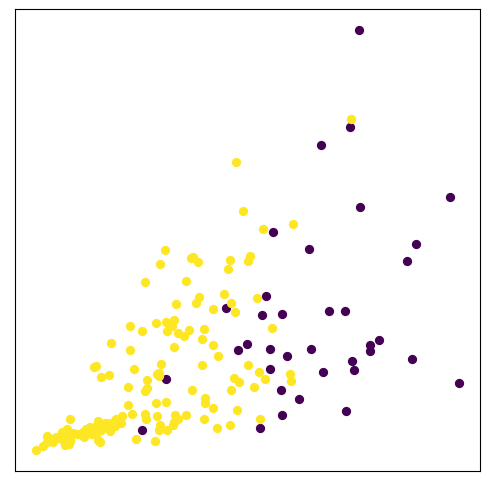

In [18]:
# Establecemos el número de clusters
clusters = 2

# Obtenemos las etiqutas para cada cluster
y_hat = fcluster(Z, clusters, criterion='maxclust')

# Graficamos nuestro resultado
plotClusters(X, y_hat)

Usando 2 clusters no existe una gran diferenciación, de hecho los puntos del grafo están juntos y no muy bien diferenciados.

Veamos como se ve esto para 3 clusters:

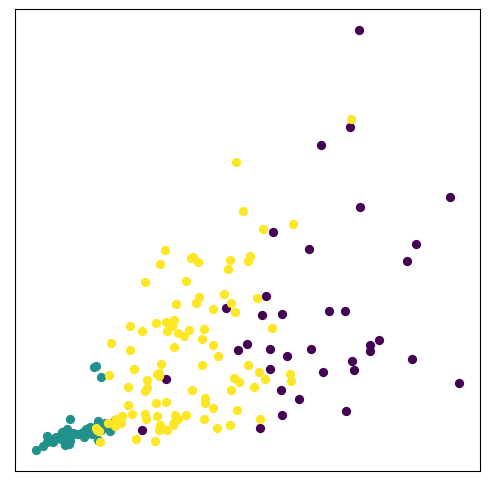

In [52]:
# Establecemos el número de clusters
clusters = 3

# Obtenemos las etiqutas para cada cluster
y_hat = fcluster(Z, clusters, criterion='maxclust')

# Graficamos nuestro resultado
plotClusters(X, y_hat)

COmo se puede apreciar, mejora un poco, aunque aún no existe una diferenciación clara ya que datos que pertenecen a otro clusters pero se encuentran cerca de otras nubes de puntos.

### Selección de clusters para K-Means

Ahora avanzaremos a la implementación del algoritmo K-Means, pero sabiendo que existen los métodos **Elbow**, **Silueta** y **VAT** para determinar el número óptimo de clusters, primero procederemos a implementar dichos métodos: 

#### Elbow

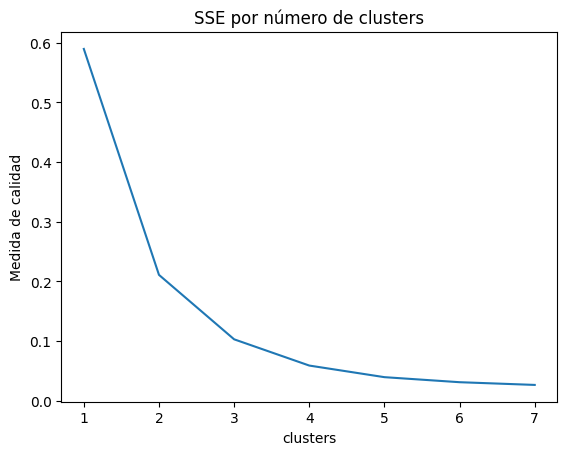

In [20]:
clusters = [x for x in range(1,8)]
sse_list = []

for cluster in clusters:
    modelo_kmeans = KMeans(n_clusters = cluster)
    modelo_kmeans.fit(X)
    sse_list.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1)
ax.set_xticks(clusters)
ax.set_title("SSE por número de clusters")
ax.set_xlabel('clusters')
ax.set_ylabel('Medida de calidad')
ax.plot(clusters, sse_list)

Vemos que usando el método **Elbow**, la selección del número de clusters es 3.

#### Silueta

Text(0, 0.5, 'Medida de calidad')

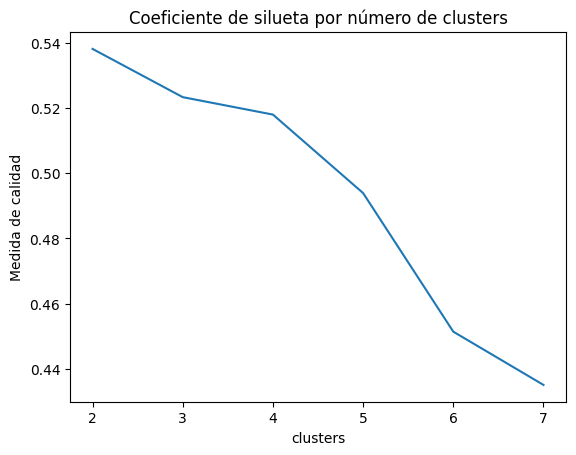

In [21]:
clusters = [x for x in range(2,8)]
lista_siluesta_score = []

for cluster in clusters:
    modelo_kmeans = KMeans(n_clusters = cluster)
    y_hat = modelo_kmeans.fit_predict(X)
    silueta_score = silhouette_score(X, y_hat)
    lista_siluesta_score.append(silueta_score)
    
fig, ax = plt.subplots(1, 1)
ax.set_xticks(clusters)
ax.plot(clusters, lista_siluesta_score)
ax.set_title("Coeficiente de silueta por número de clusters")
ax.set_xlabel('clusters')
ax.set_ylabel('Medida de calidad')

Al igual que con el conjunto de datos de Iris, los primeros clusters son los que tienen los mayores coeficientes, en este caso se obtiene la mejor puntuación en 2 clusters.

#### VAT

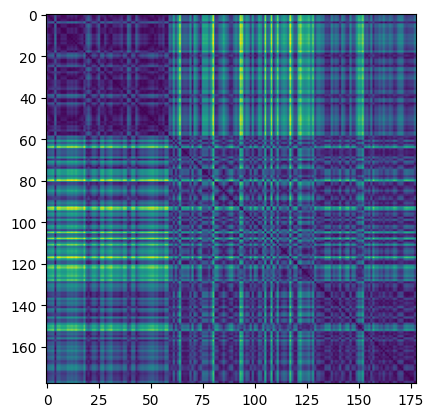

In [64]:
from scipy.spatial.distance import pdist, squareform

dist_euclidean = pdist(X, 'euclidean')

m = np.max(dist_euclidean)

n = len(X)

D = squareform(dist_euclidean)/m #Normalizamos entre el valor máximo

fig, ax = plt.subplots()
im = ax.imshow(D)

Utilizando el método VAT obtenemos, al parecer, 2 clusters como la mejor opción aunque no es tan claro el resultado.

### Modelo K-Means 

Utilizando el método Elbow, vemos que el número óptimo de clusters son 3, sin embargo, utilizando el método Silueta y VAT señalan que el número óptimo de clusters son 2:

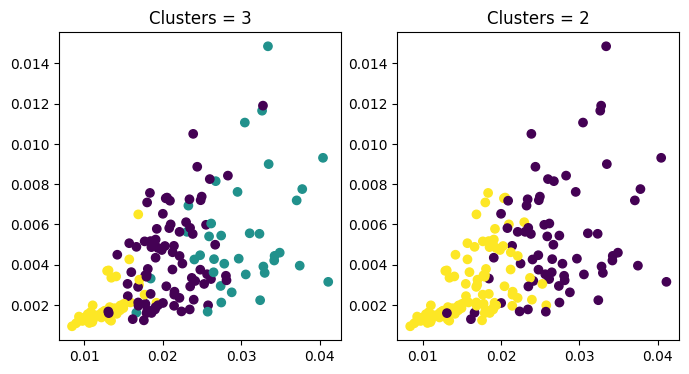

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

clusters = [2, 3]

for i in range(1,3):
    model_kmeans = KMeans(n_clusters = clusters[i - 1])
    y_hat = model_kmeans.fit_predict(X = X)
    ax[i - 1].scatter(x = X[:, 0],
               y = X[:, 1], 
               c = y_hat)
    ax[i - 1].set_title(f'Clusters = {clusters[i - 1]}')

Como se puede apreciar, la selección de 3 clusters para ser el resultado óptimo ya que se encuentran mejor diferenciados los puntos que en el caso con 2.

### Comparativa de calidad

#### Medidas Internas

Para el SSE tenemos el método `inertia_` que permite obtener el SSE por cada cluster añadido, estos resultados los guardamos en la variable `sse_list`:

In [72]:
sse_list

[6.675330509968506,
 0.5544050220763209,
 0.3226817404832856,
 0.26930439485337887,
 0.2307993772308734,
 0.19839710525234303,
 0.181422560531162]

Para el coeficiente de Silueta utilizamos el método `silhouette_score` y los resultados lo guardamos en la variable `lista_siluesta_score`:

In [73]:
lista_siluesta_score

[0.81924350789413,
 0.576326476810026,
 0.5402408637509504,
 0.3563379689755707,
 0.31980892626557306,
 0.2977703374079819]

#### Medidas Externas

Para la evaluación del **recall**, **precision** y **F1** utilizaremos la función `classification_report()` que se encuentra en la librería de `metrics` de `sklearn`. En este caso veamos que resulta de hace una agrupación con solo dos clusters:

In [84]:
y_hat_fix = []

for i in y_hat:
    if i == 0:
        y_hat_fix.append(1)
    elif i == 1:
        y_hat_fix.append(0)

y_hat_fix = np.array(y_hat_fix)

print(classification_report(wine.target, np.array(y_hat_fix)))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        59
           1       0.69      0.66      0.68        71
           2       0.00      0.00      0.00        48

    accuracy                           0.60       178
   macro avg       0.41      0.55      0.46       178
weighted avg       0.45      0.60      0.50       178



/home/antonio/anaconda3/envs/INFOTECp38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antonio/anaconda3/envs/INFOTECp38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/antonio/anaconda3/envs/INFOTECp38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Como se puede ver, quedó un etiquetado o cluster sin clasificar, esto impacta directamente en las medidas pues no se logró diferenciar entre los etiquetados 0, 1 y 2.

Ahora veamos cómo se comporta para 3 clusters:

In [79]:
y_hat_fix = []

for i in y_hat:
    if i == 0:
        y_hat_fix.append(1)
    elif i == 1:
        y_hat_fix.append(0)
    elif i == 2:
        y_hat_fix.append(2)

y_hat_fix = np.array(y_hat_fix)

print(classification_report(wine.target, np.array(y_hat_fix)))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86        59
           1       0.89      0.46      0.61        71
           2       0.49      0.83      0.62        48

    accuracy                           0.70       178
   macro avg       0.75      0.72      0.70       178
weighted avg       0.77      0.70      0.70       178



Se aprecia una mejora considerable ya que si logra diferenciar entre los 3 etiquetados, la precisión macro es del 75%, el recall macro  72% y F1-score tienen un valor del 70%.

## Conclusiones

Vimos diferentes técnicas de agrupamiento, en dos conjuntos de datos, por un lado el conjunto de datos Iris resulta perfecto y fácil de entender, mientras que los datos de Wine son casos más cercanos a la realidad pues a pesar de ocupar los métodos y las medidas apropiadas resulta difícil lograr hacer la selección del número de clusters de manera rápida, este ejercicio muestra que este tipo de aprendizaje o clasificación es un proceso iterativo de prueba y error, dónde podemos aplicar continuamente ajuste y cambios al momento de hacer los agrupamientos.